In [1]:
import netCDF4 as nc
import glob
import numpy as np
import time as ti
import matplotlib.pylab as py
from IPython.display import display, clear_output
import numpy.ma as ma
import warnings
warnings.filterwarnings('ignore')
from scipy import optimize
import numpy.ma as ma
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import hickle as hkl
import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import shapely.geometry as shp
import shapely.ops as ops
from rtree import index
from datetime import datetime
import glob
import matplotlib
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import cartopy.feature as cfeature

from functools import partial
import pyproj 

import logging
import time as ti
                
from pathlib import Path
import os
import calendar
from scipy import stats

import sys
sys.path.append('/data/pragallva/2023_repeat_ERA5/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import netcdf_utilities as ncutil
import os
# os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
from tqdm import tqdm
import glob
from PIL import Image
import copy
import itertools
from datetime import date
import temporal_filter_for_all_years_in_one_level_with_seasonal_cycle as tf
import scipy as sc
from scipy.interpolate import interp1d

NH =''
SH ='S'

import matplotlib
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", \
              [ "navy",  "dodgerblue", "PowderBlue", "white", \
                "khaki", "orange", "darkred"])

In [2]:
def science_blocks():
    py.plot(-9, 45,   'k*',   markersize=20,)# mfc='none')
    py.plot(-9, 45,   'wo',   markersize=2, )# mfc='none')
    py.plot(-147, 42, 'k*',   markersize=20,)# mfc='none')
    py.plot(-147, 42, 'wo',   markersize=2, )# mfc='none')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from scipy.signal import savgol_filter

month_names  = {0:'Jan',   1:'Feb',    2:'Mar',    3:'Apr',    4:'May',   5:'Jun',   6:'Jul',    7:'Aug',    8:'Sep',    9:'Oct',    10:'Nov',    11:'Dec'    }
days_no_leap = {  'Jan':31,  'Feb':28,   'Mar':31,   'Apr':30,   'May':31,  'Jun':30,  'Jul':31,   'Aug':31,   'Sep':30,   'Oct':31,    'Nov':30,    'Dec':31 }
days_leap    = {  'Jan':31,  'Feb':29,   'Mar':31,   'Apr':30,   'May':31,  'Jun':30,  'Jul':31,   'Aug':31,   'Sep':30,   'Oct':31,    'Nov':30,    'Dec':31 }

def leap_day(year):
    if calendar.isleap(year+1979):
        return days_leap
    else:
        return days_no_leap
        
source_NH                 = '/data/pragallva/2023_repeat_ERA5/post_processing/parameters/'
A_N                       = h5saveload.load_dict_from_hdf5(source_NH+'A_N.hdf5')
lat_N,  lon_N,  A_N_daily = A_N['lat'], A_N['lon'], A_N['field']

source_NH                 = '/data/pragallva/2023_repeat_ERA5/post_processing/parameters/'
F1_N                       = h5saveload.load_dict_from_hdf5(source_NH+'F1_N.hdf5')
F2_N                       = h5saveload.load_dict_from_hdf5(source_NH+'F2a_N.hdf5')
F3_N                       = h5saveload.load_dict_from_hdf5(source_NH+'F3_N.hdf5')

lat_N,  lon_N,  F_N_daily = F1_N['lat'], F1_N['lon'], (F1_N['field']+F2_N['field']+F3_N['field'])

source_NH                 = '/data/pragallva/2023_repeat_ERA5/post_processing/parameters/'
A_N                       = h5saveload.load_dict_from_hdf5(source_NH+'A_N.hdf5')
lat_N,  lon_N,  A_N_daily = A_N['lat'], A_N['lon'], A_N['field']

source_NH     = '/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/seasonal/'
A_N_seasonal  = h5saveload.load_dict_from_hdf5(source_NH+'A_N.hdf5')
lat_N,  lon_N,  A_N_seasonal = A_N['lat'], A_N['lon'], A_N_seasonal['field']


A0_mini     = A_N_seasonal[:,[0,1,11],...].mean(axis=0).mean(axis=0).mean(axis=0)
annual_mean = np.nanmean(np.nanmean(np.nanmean(A_N_daily, axis=0), axis=0), axis=0)

In [3]:
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
total_data_dictionary = hkl.load(source+'/DELETE_REDUNDANT_BLOCKS.hkl')

In [4]:
total_data_dictionary.keys()

dict_keys(['lonp0-p60_lat30-45', 'lonp0-p60_lat45-60', 'lonp0-p60_lat60-75', 'lonm60-m0_lat20-30', 'lonm60-m0_lat30-45', 'lonm60-m0_lat45-60', 'lonm60-m0_lat60-75', 'lonp60-p120_lat45-60', 'lonp60-p120_lat60-75', 'lonm120-m60_lat30-45', 'lonm120-m60_lat45-60', 'lonm120-m60_lat60-75', 'lonp120-p180_lat30-45', 'lonp120-p180_lat45-60', 'lonp120-p180_lat60-75', 'lonm180-m120_lat20-30', 'lonm180-m120_lat30-45', 'lonm180-m120_lat45-60'])

## Look at the covariance correlation matrix

In [5]:
# Add a map here 
def plot_cluster_with_map_modified_for_subplots(TITLE='Spatial distribution of persistent wave-activity',\
                          DATA = np.nanmean(A0_mini,axis=0),\
                          LRANGE = np.arange(-110,-0, 10),\
                          CMAP  = matplotlib.colors.LinearSegmentedColormap.from_list("", \
                                  [ "navy", "skyblue", "khaki",  "white", ]),\
                          LEGEND_LOCATION='upper right', ALPHA=0.8, lat_N=lat_N, track_events=True, \
                          source = '/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/', \
                          lat_locations='ALL', EXTRA='', xlabelling = True, fig=None, fig_no = 111, block_legends=True, \
                                                bbox_to_anchor=(0, -0.40)):
    
    
            import matplotlib
            def plot_tracked_events(axes, persistence_length = range(3,5), color='gray', alpha=0.6, markeredgecolor=None, markersize=18, projection=ccrs.PlateCarree(), marker='o'):
                
                for lon_region in os.listdir(source):
                    
                    if lat_locations=='ALL':
                        lat_regions = os.listdir(source+'/%s/'%(lon_region))
                    else:
                        lat_regions = [lat_locations]
                        
                    for lat_region in lat_regions:
                        
                        blocking_details_day_wise = hkl.load('%s/%s/%s/%s/DELETE_REDUNDANT_BLOCKS/blocking_details_day_wise.hkl'%(source, lon_region, lat_region, EXTRA))
                        DAYS = list(blocking_details_day_wise.keys())
                        
                        for DAY in DAYS:
                            day = int(DAY.split('days')[-1])
                            
                            if day in persistence_length:
                                for block_no in blocking_details_day_wise[DAY].keys():
                                    xy = blocking_details_day_wise[DAY][block_no]['location']
                                    
                                    if color == 'k':
                                          axes.plot(*(xy), '.', alpha=0.8, color='k',transform=projection, mfc='none', markersize=10,  marker='o')
                                    else:
                                          axes.plot(*(xy), '.', alpha=alpha, color=color,transform=projection, markeredgewidth=2, markeredgecolor=markeredgecolor, markersize=markersize, marker=marker)
                                    
            
            
            def custom_block_legends(fs=20, location='best'):
                from matplotlib.lines import Line2D
                custom_lines = [Line2D([0], [0], marker='o', color='w' , mfc='none', markersize=15, markeredgecolor='gray', markeredgewidth=2),
                                Line2D([0], [0], marker='o', markerfacecolor='lime',color='w' ,  markersize=15, markeredgecolor='k'),
                                Line2D([0], [0], marker='o', markerfacecolor='orange', color='w',  markersize=15, markeredgecolor='k'),
                                Line2D([0], [0], marker='o', markerfacecolor='maroon', color='w', markersize=18, markeredgecolor='w'),]


                py.legend(custom_lines, ['4-5 days', '6-8 days', '9-11 days', '12-17 days'], ncol=2, fontsize=fs, loc=location, bbox_to_anchor = bbox_to_anchor)
                            

            def plotLWA_and_blocking_events(field=A_N_daily, variable='LWA', \
                                            x=lon_N, y=lat_N, plot_field=True, format='%1d', \
                                            color='r',plot_specific=0, axes=None, projection=ccrs.PlateCarree(), ):

                if axes is None:
                    axes=py

                def science_blocks():
                    axes.plot(-9, 45,   'k*',   markersize=20,transform=projection)# mfc='none')
                    axes.plot(-9, 45,   'wo',   markersize=2, transform=projection)# mfc='none')
                    axes.plot(-147, 42, 'k*',   markersize=20,transform=projection)# mfc='none')
                    axes.plot(-147, 42, 'wo',   markersize=2, transform=projection)# mfc='none')
                import matplotlib.pyplot as plt
                plt.rcParams.update({'font.size': 15})


                Y     = 2022
                start = 1980
                LWA_mean=[]
                
                if track_events:    
                    plot_tracked_events(axes,  persistence_length = range(4,5+1),   color='k', markersize=10, projection=projection)
                    plot_tracked_events(axes,  persistence_length = range(6,8+1),   color='lime', markeredgecolor='k',   markersize=15, projection=projection,  marker='o')
                    plot_tracked_events(axes,  persistence_length = range(9,11+1),  color='orange', markeredgecolor='k', markersize=20, projection=projection, alpha=0.8, marker='o')
                    plot_tracked_events(axes,  persistence_length = range(12,17+1), color='maroon', markeredgecolor='w', markersize=25,projection=projection, alpha=0.6, marker='o')
                    if block_legends is True:
                        custom_block_legends(fs=default_size_label, location=LEGEND_LOCATION)

                if plot_field:
                    c=axes.contour(x, y, np.nanmean(LWA_mean, axis=0), colors=color, linewidths=2.0,transform=projection)
                    axes.clabel(c, fontsize=18, fmt=format)
                if plot_specific:
                    c=axes.contour(x, y, np.nanmean(LWA_mean, axis=0), [plot_specific], color='k', linewidths=4.0, transform=projection)
                    axes.clabel(c, fontsize=15, fmt=format)

                axes.set_ylim([20,80])
                axes.set_xlim([-180,180])

#                 science_blocks()

                if plot_field:
                    return np.nanmean(LWA_mean, axis=0)


            CL=-90
            projection=ccrs.PlateCarree(central_longitude=CL)


            ax = fig.add_subplot(fig_no, projection=projection)
            matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
            LWA_all=plotLWA_and_blocking_events(field=A_N_daily, variable='LWA', plot_field=False, axes=ax, projection=ccrs.PlateCarree())
            
            cyclic_data, cyclic_lons = cutil.add_cyclic_point(data=DATA, coord=lon_N)
            im=ax.contourf(cyclic_lons,lat_N, cyclic_data, LRANGE, \
                          cmap=CMAP, transform=ccrs.PlateCarree(), alpha=ALPHA, extend='both'); #fig.colorbar(c)
            ax.contour(cyclic_lons,lat_N, cyclic_data,    LRANGE, \
                          colors='w', transform=ccrs.PlateCarree(), alpha=0.3); #fig.colorbar(c)

            ax.set_aspect('auto')
            ax.coastlines(linestyle='-', color='k')
#             ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='thistle', alpha=0.2))

            ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=projection)
            ax.set_yticks([-75, -50, -25, 0, 25,  50, 75], crs=projection)
            ax.set_extent((0-CL, 360+CL, 25, 80), crs=projection)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            ax.set_ylabel('Latitude', fontsize=default_size_label)
            ax.set_title(TITLE,fontsize=default_size_title, y=1.01, color='black')
            ax.tick_params(labelsize=default_size_label, labelbottom=xlabelling)
            if xlabelling:
                ax.set_xlabel('Longitude', fontsize=default_size_label)   
                
            ax.text(-170, 70, TITLES[TITLE], \
                            bbox={'facecolor': 'white', 'alpha': 0.9, 'pad': 10}, \
                            fontsize=default_size_title, color='k')
            return ax, im
        
#             ax.set_xticks([], crs=projection)                    
#             py.show()

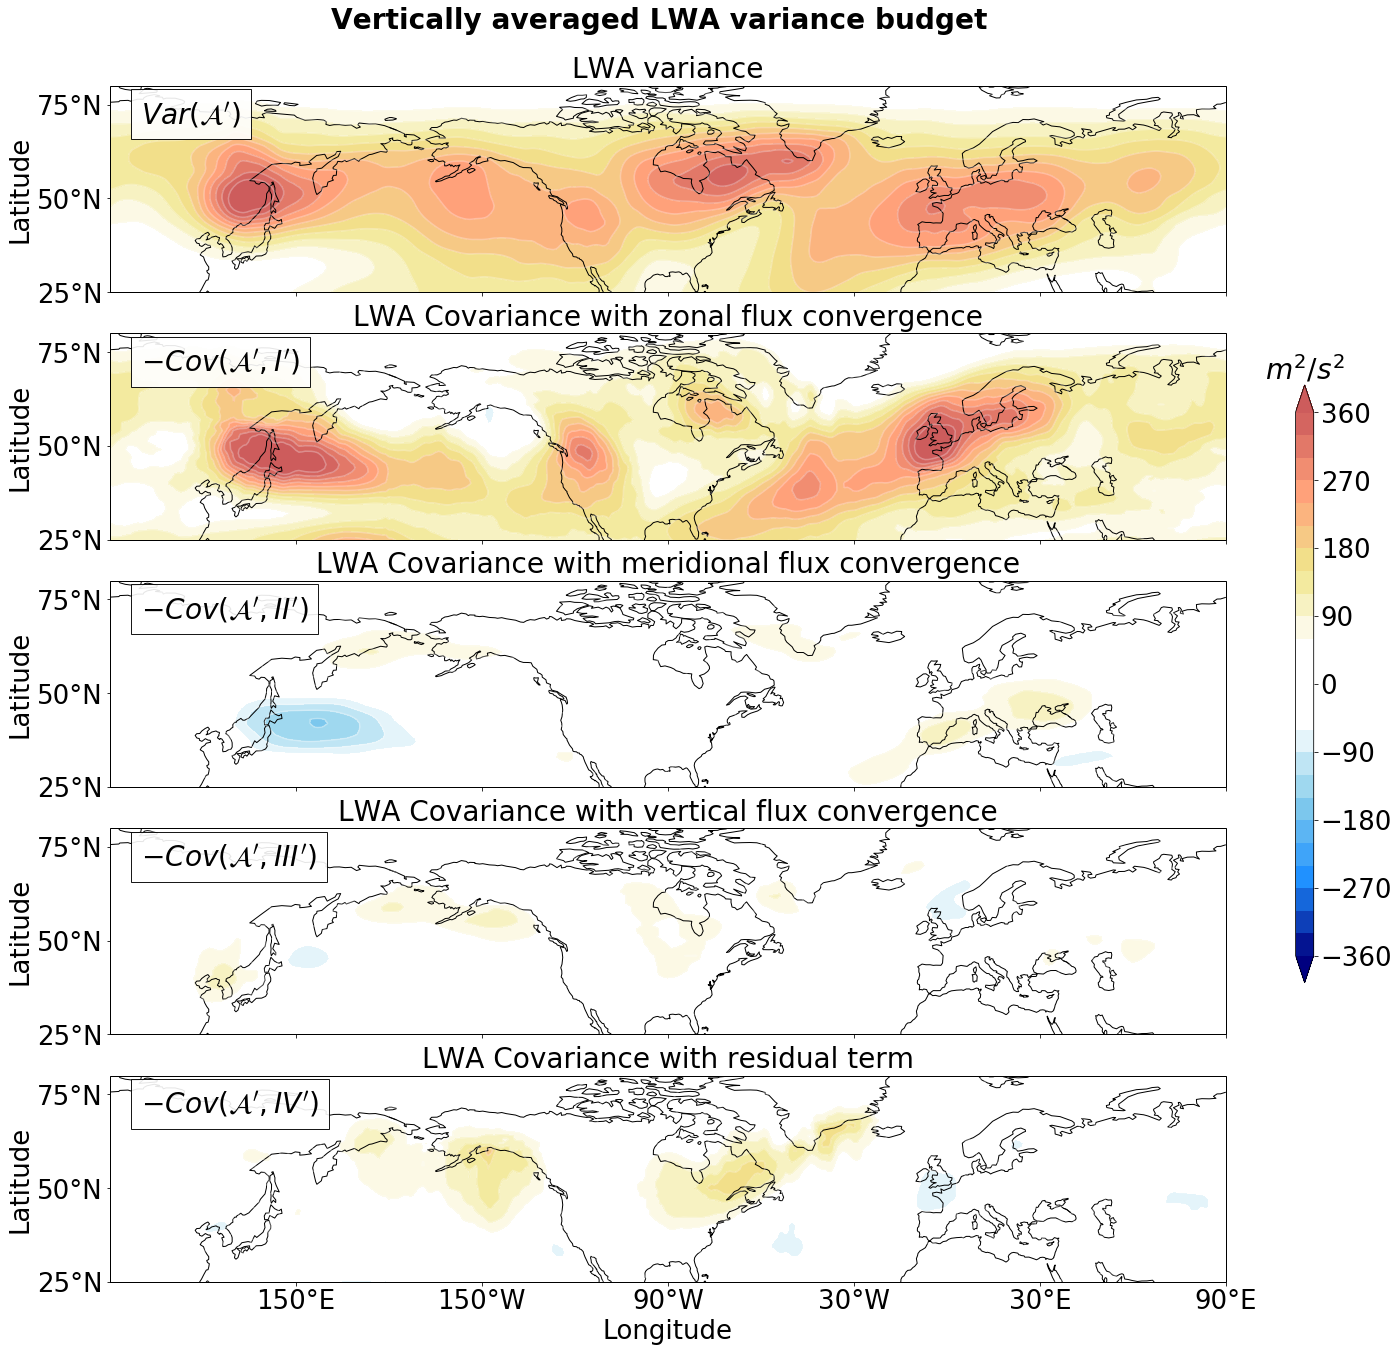

In [6]:
TITLES = {'LWA variance'                                         : r'$  {Var {\left({\mathcal{A}}^\prime\right)}} $', \
          'LWA Covariance with zonal flux convergence'           : r'$  {-Cov{\left({\mathcal{A}}^\prime, {I}^{\prime}\right)}} $', \
          'LWA Covariance with meridional flux convergence'      : r'$  {-Cov{\left({\mathcal{A}}^\prime, {II}^{\prime}\right)}}  $', \
          'LWA Covariance with vertical flux convergence'        : r'$  {-Cov{\left({\mathcal{A}}^\prime, {III}^{\prime}\right)}}  $', \
          'LWA Covariance with residual term'                    : r'$  {-Cov{\left({\mathcal{A}}^\prime, {IV}^{\prime}\right)}}  $'}

# TITLES = [r'$ Cov (\Delta A^\prime,{ \int_t^{t+\Delta t} -\partial_{x}F^{\prime}dt }) $']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "white", "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "indianred", "lightsalmon", "khaki", "white", "white", "skyblue", "dodgerblue", "navy"][::-1])

lrange = np.arange(-60,65,5)*6

source0 = "/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/band_pass_time_filter_004-infy_days/covar_corr/variance/"
source_file = h5saveload.load_dict_from_hdf5(source0+'dict_DJF_04_a.hdf5')
    
# default_size_label   = 15
# default_size_title   = 18
# default_size_contour = 16

default_size_label   = 25+1
default_size_title   = 25+3
default_size_contour = 16+2

fig = py.figure(figsize=(25,22))
# dest = '/data/pragallva/Spring_quarter_2020/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'

axs=[]; enum=-1
for  key, title_key in zip(['dA_dt_dAdt_integral',       \
                            'dF_dx_dAdt_integral',       \
                            'dF_EPy_dy_dAdt_integral', \
                            'dF_EPz_dz_dAdt_integral',   \
                            'residual_dAdt_integral'], TITLES.keys()):
    
        enum = enum+1
        xlabelling = True if enum == 4 else False
        ax, im = plot_cluster_with_map_modified_for_subplots( TITLE  =  title_key, \
                                                              DATA   =  source_file[key], \
                                                              LRANGE =  lrange,           \
                                                              CMAP   =  cmap1,     \
                                                              LEGEND_LOCATION = 'lower left', \
                                                              ALPHA=1, track_events=False, \
                                                              xlabelling = xlabelling, fig=fig, fig_no = 511+enum)
        axs.append(ax)

        
cbar = fig.colorbar(im, ax=axs, orientation='vertical',  shrink=0.5,     aspect=30)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(default_size_label)
fig.suptitle('Vertically averaged LWA variance budget', fontsize = default_size_title, y=0.93, x=0.43, fontweight='bold')
cbar.ax.set_title(r'$m^2/s^2$', fontsize=default_size_title)


dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Wave_activity_variance.png',  dpi=300, bbox_inches='tight')
fig.savefig(dest+'Wave_activity_variance.pdf',           bbox_inches='tight')

fig.show()

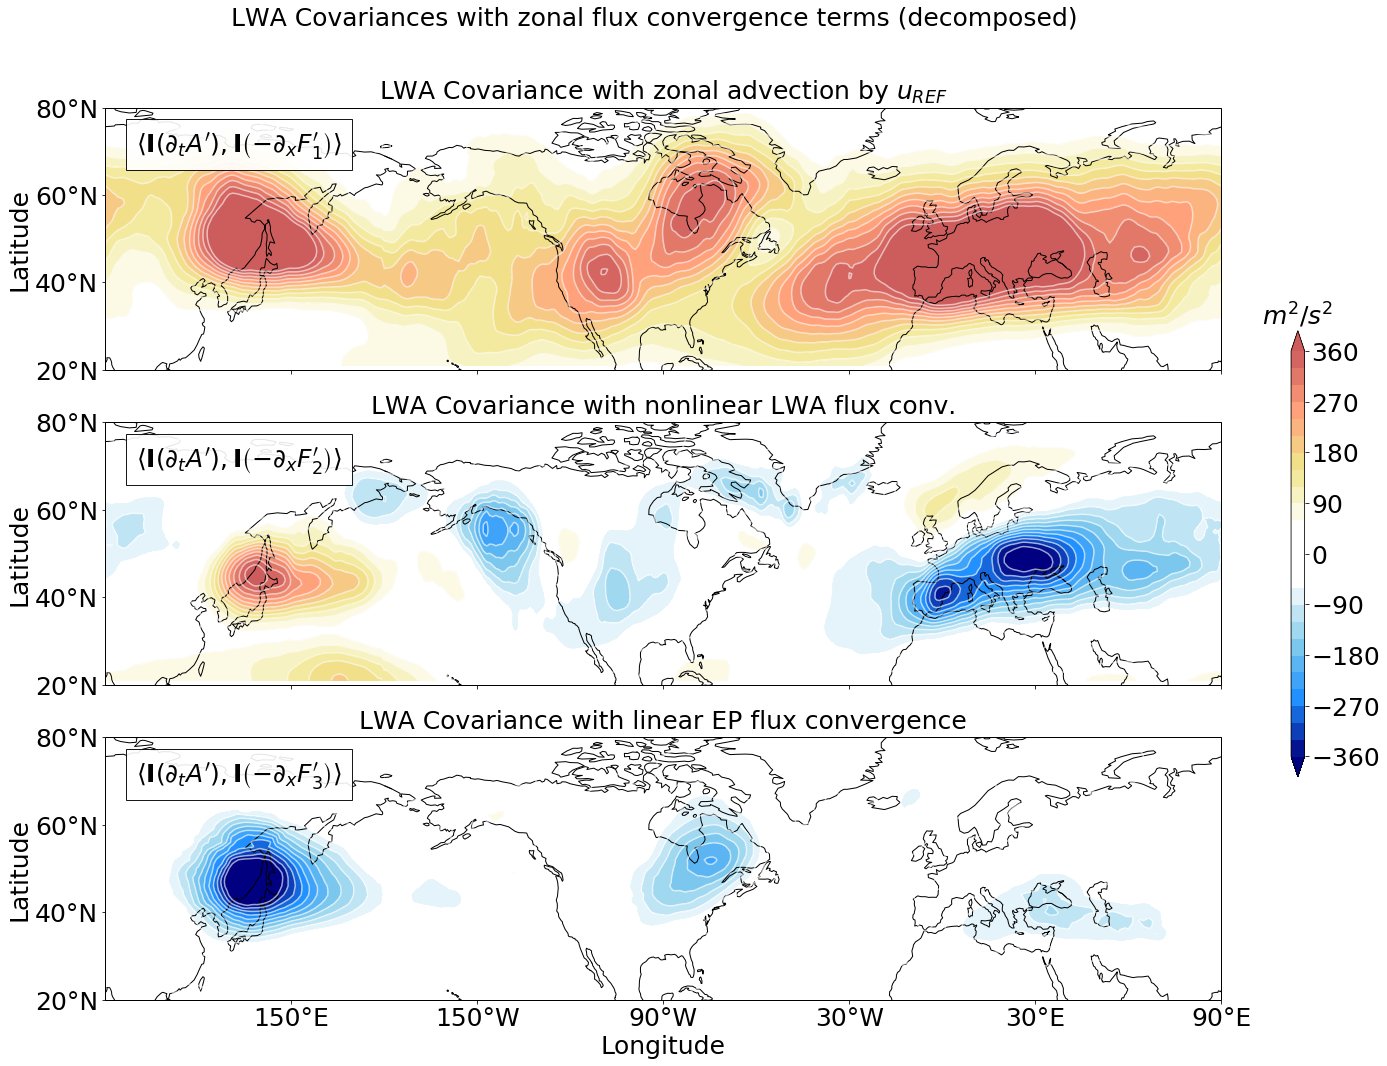

In [12]:
TITLES = {r'LWA Covariance with zonal advection by $u_{REF}$'     : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_1}}\right)} \rangle $', \
          'LWA Covariance with nonlinear LWA flux conv.' : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_2}}\right)} \rangle $', \
          'LWA Covariance with linear EP flux convergence'     : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_3}}\right)} \rangle $'}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "white", "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "indianred", "lightsalmon", "khaki", "white", "white", "skyblue", "dodgerblue", "navy"][::-1])

lrange = np.arange(-60,65,5)*6

source0 = "/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/band_pass_time_filter_004-infy_days/covar_corr/variance/"
source_file = h5saveload.load_dict_from_hdf5(source0+'dict_DJF_04_a.hdf5')
    
default_size_label   = 25
default_size_title   = 25
default_size_contour = 16

fig  = py.figure(figsize=(25, 28))

axs=[]; enum=-1
for  key, title_key in zip(['dF1_adv_dx_dAdt_integral', \
                            'dF2_adv_dx_dAdt_integral', \
                            'dF_EPx_dx_dAdt_integral'], TITLES.keys()):

        enum = enum+1
        xlabelling = True if enum == 2 else False
        ax, im =plot_cluster_with_map_modified_for_subplots(  TITLE  =  title_key,\
                                                              DATA   =  source_file[key], \
                                                              LRANGE =  lrange,                \
                                                              CMAP   =  cmap1,     \
                                                              LEGEND_LOCATION='lower left', ALPHA=1, track_events=False, \
                                                              xlabelling = xlabelling, fig=fig, fig_no = 511+enum)
        axs.append(ax)

cbar = fig.colorbar(im, ax=axs, orientation='vertical',         shrink=0.5,     aspect=30)
cbar.ax.set_title(r'$m^2/s^2$', fontsize=default_size_title)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(default_size_label)
fig.suptitle('LWA Covariances with zonal flux convergence terms (decomposed)', \
             fontsize=default_size_title, y=0.93, x=0.43, fontweight='bold')
fig.show()
# ax1.get_shared_x_axes().join(ax1, ax2)
# ax1.get_shared_y_axes().join(ax1, ax2)

dest = '/data/pragallva/2023_repeat_ERA5/2023_notebooks_for_paper/'

os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Wave_activity_variance_decomposed.png',  dpi=300, bbox_inches='tight')
fig.savefig(dest+'Wave_activity_variance_decomposed.pdf',           bbox_inches='tight')




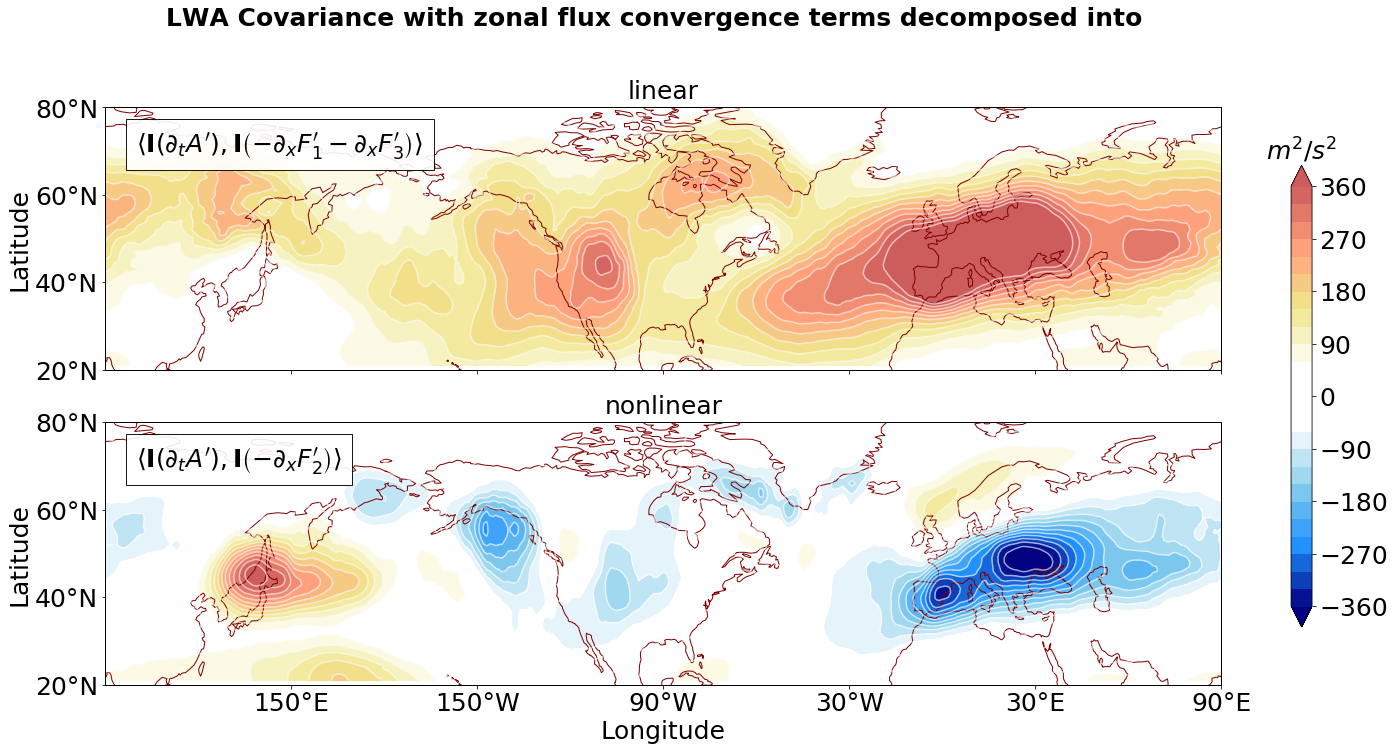

In [24]:
TITLES = {'linear'     : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_1 -\partial_{x} F^{\prime}_3}}\right)} \rangle $', \
          'nonlinear'  : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_2}}\right)} \rangle $', }

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "white", "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "indianred", "lightsalmon", "khaki", "white", "white", "skyblue", "dodgerblue", "navy"][::-1])

lrange = np.arange(-60,65,5)*6

source0 = "/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/band_pass_time_filter_004-infy_days/covar_corr/variance/"
source_file = h5saveload.load_dict_from_hdf5(source0+'dict_DJF_04_a.hdf5')
    
default_size_label   = 25
default_size_title   = 25
default_size_contour = 16

fig  = py.figure(figsize=(25, 28))

source_file['dF13_adv_dx_dAdt_integral'] = source_file['dF1_adv_dx_dAdt_integral']+\
                                           source_file['dF_EPx_dx_dAdt_integral']

axs=[]; enum=-1
for  key, title_key in zip(['dF13_adv_dx_dAdt_integral', \
                            'dF2_adv_dx_dAdt_integral', ], TITLES.keys()):

        enum = enum+1
        xlabelling = True if enum == 1 else False
        ax, im =plot_cluster_with_map_modified_for_subplots(  TITLE  =  title_key,         \
                                                              DATA   =  source_file[key],  \
                                                              LRANGE =  lrange,            \
                                                              CMAP   =  cmap1,             \
                                                              LEGEND_LOCATION='lower left',\
                                                              ALPHA=1, track_events=False, \
                                                              xlabelling = xlabelling, fig=fig, fig_no = 511+enum)
        axs.append(ax)

cbar = fig.colorbar(im, ax=axs, orientation='vertical',         shrink=0.8,     aspect=20)
cbar.ax.set_title(r'$m^2/s^2$', fontsize=default_size_title)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(default_size_label)
fig.suptitle('LWA Covariance with zonal flux convergence terms decomposed into', \
             fontsize=default_size_title, y=0.93, x=0.43, fontweight='bold')
fig.show()
# ax1.get_shared_x_axes().join(ax1, ax2)
# ax1.get_shared_y_axes().join(ax1, ax2)

dest = '/data/pragallva/2023_repeat_ERA5/2023_notebooks_for_paper/'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Wave_activity_variance_decomposed.png',  dpi=300, bbox_inches='tight')
fig.savefig(dest+'Wave_activity_variance_decomposed.pdf',           bbox_inches='tight')


## With block clusters

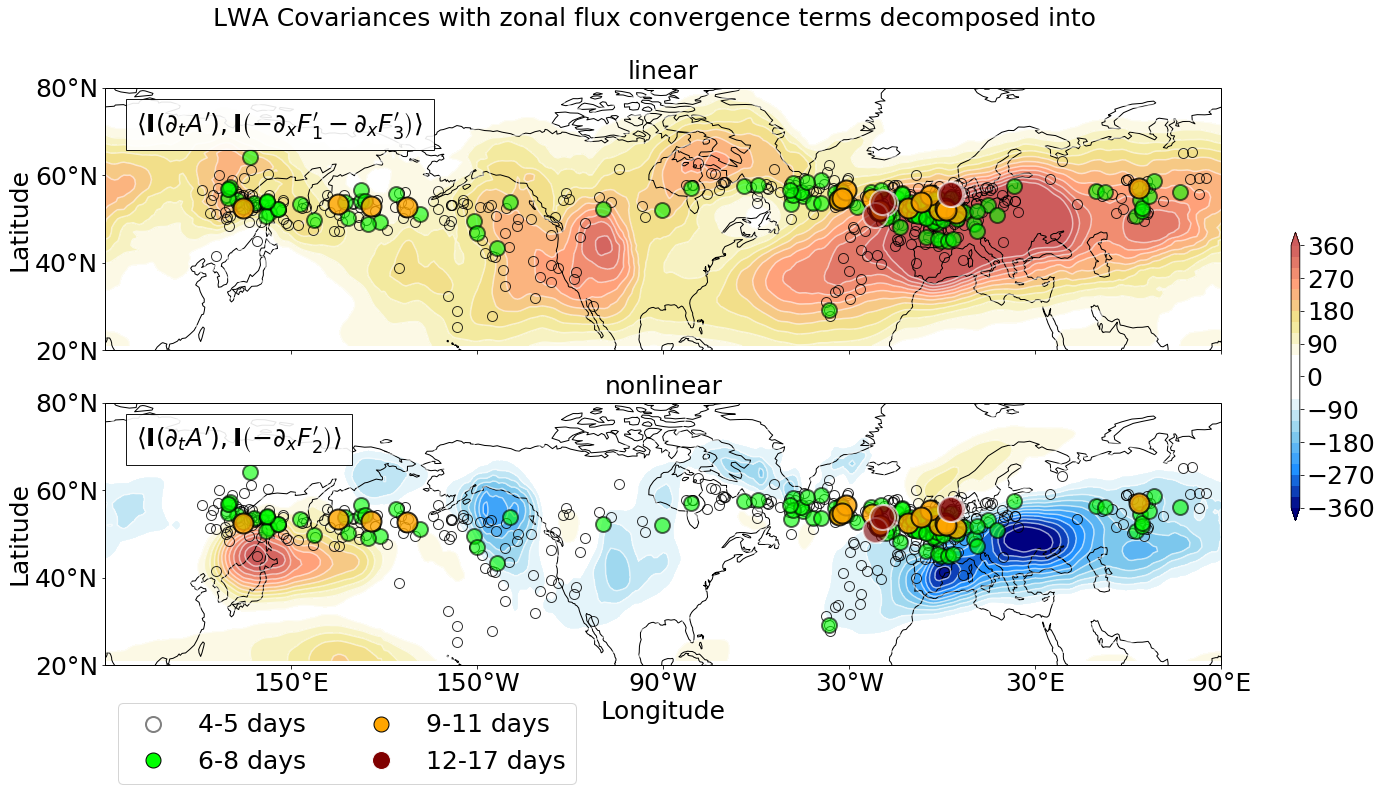

In [56]:
# TITLES = {'LWA Covariance with linear LWA flux adv.'     : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_1 -\partial_{x} F^{\prime}_3}}\right)} \rangle $', \
#           'LWA Covariance with nonlinear LWA flux conv.' : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_2}}\right)} \rangle $', }

TITLES = {'linear'   : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_1 -\partial_{x} F^{\prime}_3}}\right)} \rangle $', \
          'nonlinear': r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}{{F^{\prime}_2}}\right)} \rangle $', }

block_legendss = {'linear': False, 'nonlinear': True}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "white", "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "indianred", "lightsalmon", "khaki", "white", "white", "skyblue", "dodgerblue", "navy"][::-1])

lrange = np.arange(-60,65,5)*6

source0 = "/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/band_pass_time_filter_004-infy_days/covar_corr/variance/"
source_file = h5saveload.load_dict_from_hdf5(source0+'dict_DJF_04_a.hdf5')
    
default_size_label   = 25
default_size_title   = 25
default_size_contour = 16

fig  = py.figure(figsize=(25, 28))
dest = '/data/pragallva/Spring_quarter_2020/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'


source_file['dF13_adv_dx_dAdt_integral'] = source_file['dF1_adv_dx_dAdt_integral']+\
                                           source_file['dF_EPx_dx_dAdt_integral']

axs=[]; enum=-1
for  key, title_key in zip(['dF13_adv_dx_dAdt_integral', \
                             'dF2_adv_dx_dAdt_integral', ], TITLES.keys()):

        enum = enum+1
        xlabelling = True if enum == 1 else False
        ax, im =plot_cluster_with_map_modified_for_subplots(  TITLE  =  title_key,         \
                                                              DATA   =  source_file[key],  \
                                                              LRANGE =  lrange,            \
                                                              CMAP   =  cmap1,             \
                                                              LEGEND_LOCATION='lower left',\
                                                              ALPHA=1, track_events=True, \
                                                              xlabelling = xlabelling, fig=fig, fig_no = 511+enum, \
                                                              block_legends = block_legendss[title_key], bbox_to_anchor=(0, -0.50))
        axs.append(ax)

cbar = fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.5, aspect=30)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(default_size_label)
fig.suptitle('LWA Covariances with zonal flux convergence terms decomposed into', \
             fontsize=default_size_title, y=0.92, x=0.43)
fig.show()
# ax1.get_shared_x_axes().join(ax1, ax2)
# ax1.get_shared_y_axes().join(ax1, ax2)

# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Wave_activity_variance_decomposed_with_cluster.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Wave_activity_variance_decomposed_with_cluser.pdf',           bbox_inches='tight')


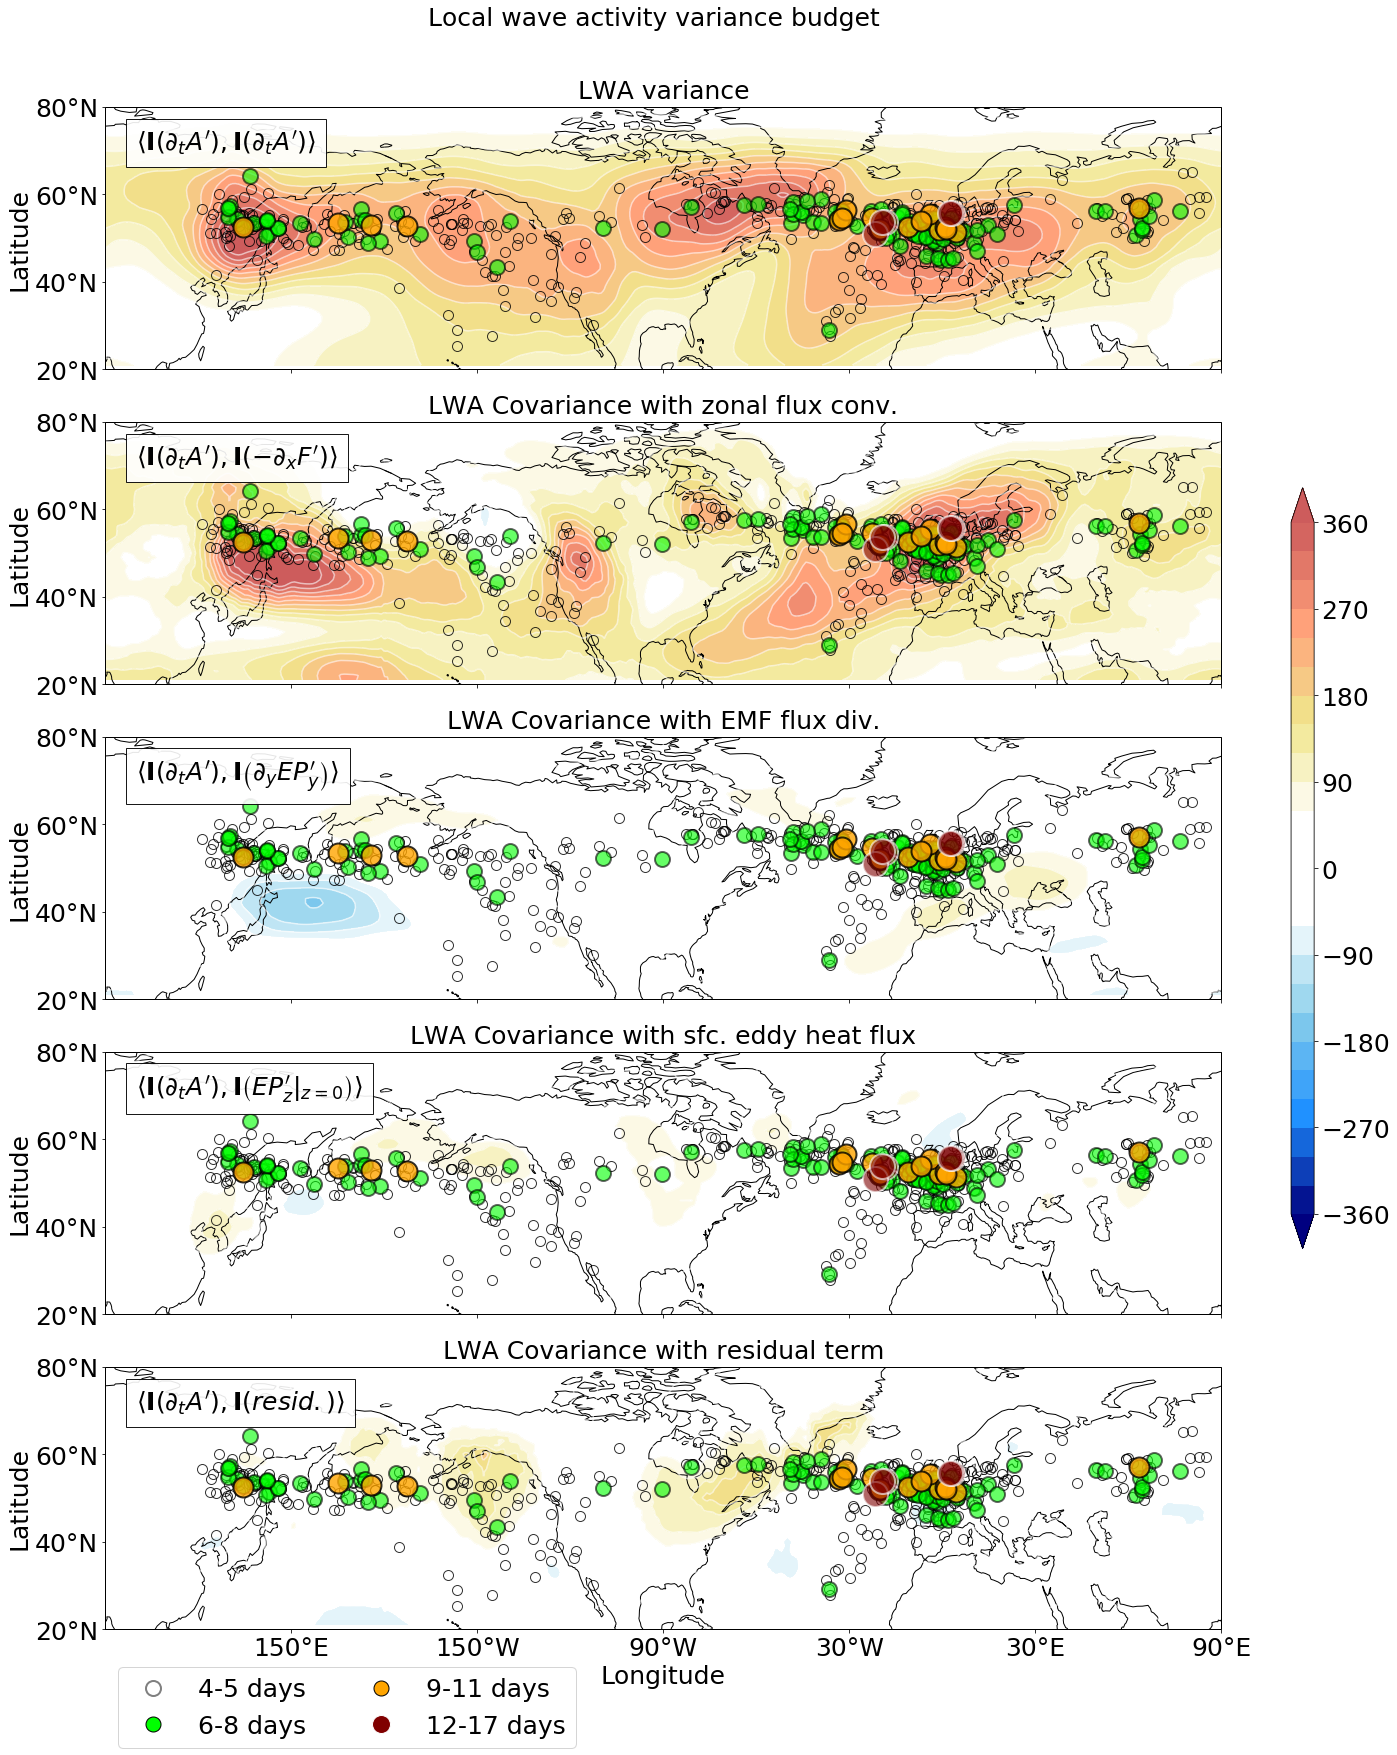

In [57]:
TITLES = {'LWA variance'                           : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)} \rangle $', \
          'LWA Covariance with zonal flux conv.'   : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(-\partial_{x}F^{\prime}\right)} \rangle $', \
          'LWA Covariance with EMF flux div.'      : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(\partial_{y}{{EP}^{\prime}_{y}}\right)} \rangle $', \
          'LWA Covariance with sfc. eddy heat flux': r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left({{{EP}^{\prime}_{z}}\vert_{z=0}}\right)} \rangle $', \
          'LWA Covariance with residual term'      : r'$ \langle{{\mathbb{\mathbf{I}}}\left(\partial_{t}A^{\prime}\right)},{{\mathbb{\mathbf{I}}}\left(resid.\right)} \rangle $'}

# TITLES = [r'$ Cov (\Delta A^\prime,{ \int_t^{t+\Delta t} -\partial_{x}F^{\prime}dt }) $']

block_legendss = {'linear': False, 'nonlinear': True}


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "white", "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "indianred", "lightsalmon", "khaki", "white", "white", "skyblue", "dodgerblue", "navy"][::-1])

lrange = np.arange(-60,65,5)*6

source0 = "/data/pragallva/2023_repeat_ERA5/post_processing/filtered_parameters/band_pass_time_filter_004-infy_days/covar_corr/variance/"
source_file = h5saveload.load_dict_from_hdf5(source0+'dict_DJF_04_a.hdf5')
    
# default_size_label   = 15
# default_size_title   = 18
# default_size_contour = 16

default_size_label   = 25
default_size_title   = 25
default_size_contour = 16

fig = py.figure(figsize=(25,28))
# dest = '/data/pragallva/Spring_quarter_2020/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'

axs=[]; enum=-1
for  key, title_key in zip(['dA_dt_dAdt_integral',       \
                            'dF_dx_dAdt_integral',       \
                            'dF_EPy_dy_dAdt_integral', \
                            'dF_EPz_dz_dAdt_integral',   \
                            'residual_dAdt_integral'], TITLES.keys()):
    
        enum = enum+1
        
        block_legends = True if enum==4 else False
        xlabelling = True if enum == 4 else False
        ax, im = plot_cluster_with_map_modified_for_subplots( TITLE  =  title_key, \
                                                              DATA   =  source_file[key], \
                                                              LRANGE =  lrange,           \
                                                              CMAP   =  cmap1,     \
                                                              LEGEND_LOCATION = 'lower left', \
                                                              ALPHA=1, track_events=True, \
                                                              xlabelling = xlabelling, fig=fig, fig_no = 511+enum, \
                                                              block_legends=block_legends, bbox_to_anchor=(0, -0.50))
        axs.append(ax)

cbar = fig.colorbar(im, ax=axs, orientation='vertical',         shrink=0.5,     aspect=30)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(default_size_label)
fig.suptitle('Local wave activity variance budget', fontsize = default_size_title, y=0.93, x=0.43)

# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Wave_activity_variance_with_cluster.png',  dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Wave_activity_variance_with_cluster.pdf',           bbox_inches='tight')

# fig.show()
# ax1.get_shared_x_axes().join(ax1, ax2)
# ax1.get_shared_y_axes().join(ax1, ax2)